# Percepción Remota

## Visualización de Sargazo

### Carlos Herrera

En este script se implementan 3 variaciones del índice de alga
flotante (FAI), adaptadas a los canales del satélite GOES R, 
para identificar colonias de sargazo en el caribe mexicano.



### FAI (original)
El primer índice que se utiliza es el FAI, propuesto por 
Chuanmin Hu (2009), que se define de la siguiente manera:

$FAI = R_{rc,NIR} – R’_{rc,NIR}$

Donde: $R’_{rc,NIR} = R_{r} + \frac{(R_{SWIR} − R_{r}) * (λ_{NIR} − λ_{r}) }{(λ_{SWIR} − λ_{r})}$

NIR: Near infrared;
SWIR: Short-wavelength infrared;
r: "red"

Al ser implementado para los canales de GOES-R, el índice FAI puede ser expresado como: 

$FAI = R(Ch3) –  R(Ch2) + \frac{(R(Ch4) – R(Ch2)) * (Ch3 – Ch2)}{(Ch4 – Ch2)}$

R(λ): Reflectancia de λ

    Ch2: "Red" 0.64 µm [0.5 km];
    Ch3: "Veggie" 0.86 µm [1 km];
    Ch4: "Cirrus" 1.37 µm [2 km];

In [1]:
# Se llaman las librerías a utilizar
import matplotlib.pyplot as plt
%matplotlib
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import numpy as np # Import the Numpy package
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
from datetime import datetime
from pyproj import Proj

# Converts the CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
# Makes a linear interpolation with the CPT file
cpt_convert = LinearSegmentedColormap('cpt', cpt)

Using matplotlib backend: Qt5Agg


Para convertir radiancias a reflectancias se utilizará la función
creada por Olmo

In [32]:
#reflectance(radiancia, numero de banda): convierte la radiancia a reflectancia las bandas 1-6 de GOES 16
def reflectance(radiance, band):
    Esun_dict = {1:726.721072,2:663.274497,3:441.868715,4:679.143879,5:634.454241,6:381.148813}
    Esun = Esun_dict[band]
    d2 = 0.3
    refl = (radiance * np.pi * d2) / Esun
    refl = np.maximum(refl, 0.0)
    refl = np.minimum(refl, 1.0)
    return refl

# Rebin function from https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [4]:
# Se establecen las rutas de los archivos (Editar a modo)
ruta = '/Users/Carlos/Desktop/Descargas GOES R/Saharan dust 20180628/Conus/L1 Radiances/'

Ch1_pth = ruta+"OR_ABI-L1b-RadC-M3C01_G16_s20181791502192_e20181791504565_c20181791505014.nc"
Ch2_pth = ruta+"OR_ABI-L1b-RadC-M3C02_G16_s20181791502192_e20181791504565_c20181791505011.nc"
Ch3_pth = ruta+"OR_ABI-L1b-RadC-M3C03_G16_s20181791502192_e20181791504565_c20181791505015.nc"
Ch4_pth = ruta+"OR_ABI-L1b-RadC-M3C04_G16_s20181791502192_e20181791504565_c20181791505009.nc"
Ch5_pth = ruta+"OR_ABI-L1b-RadC-M3C05_G16_s20181791502192_e20181791504565_c20181791505023.nc"

# Search for the Scan Start in the file name
Start = (Ch2_pth[Ch2_pth.find("_s")+2:Ch2_pth.find("_e")-1])
End = (Ch2_pth[Ch2_pth.find("_e")+2:Ch2_pth.find("_c")-1])

# Format the "Observation Start" string
datetime_start = datetime.strptime(Start,'%Y%j%H%M%S')
datetime_end = datetime.strptime(End,'%Y%j%H%M%S')
print(datetime_start)
print(datetime_end)

2018-06-28 15:02:19
2018-06-28 15:04:56


Se importan los archivos NetCDF y se extrae la radiancia de cada canal.

In [ ]:
## Ch 1
Ch1_nc = Dataset(Ch1_pth)
Ch1_rad = Ch1_nc.variables['Rad'][:]
Ch1_nc.close()
Ch1_nc = None

In [5]:
## Ch 2
Ch2_nc = Dataset(Ch2_pth)
Ch2_rad = Ch2_nc.variables['Rad'][:]
Ch2_nc.close()
Ch2_nc = None

In [ ]:
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(Ch2_rad, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.title('Ch2 "Red" (0.64 µm)')
plt.show()

In [6]:
# Ch 3
Ch3_nc = Dataset(Ch3_pth)
Ch3_rad = Ch3_nc.variables['Rad'][:]
Ch3_nc.close()
Ch3_nc = None

In [ ]:
fig = plt.figure(figsize=(4,4),dpi=150)
im = plt.imshow(Ch3_rad, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.title('Ch3 "Veggie" (0.86 µm)')
plt.show()

In [7]:
#Ch 4
Ch4_nc = Dataset(Ch4_pth)
Ch4_rad = Ch4_nc.variables['Rad'][:]

In [8]:
## Se extraen los datos de Georeferenciación 
ori_proj = Ch4_nc.variables['goes_imager_projection']
# Satellite height
sat_h = ori_proj.perspective_point_height
# Satellite longitude
sat_lon = ori_proj.longitude_of_projection_origin
# Satellite sweep
sat_sweep = ori_proj.sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = Ch4_nc.variables['x'][:] * sat_h
Y = Ch4_nc.variables['y'][:] * sat_h

p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)


In [9]:
#print(Ch4_nc.variables)
#print(Ch4_nc.dimensions)
print(sat_lon)
print(sat_h)
np.shape(lats)

-75.0
35786023.0


(1500, 2500)

In [10]:
print(np.min(lats))
print(lats[0,:])

print(np.min(lons))
print(lons[-1,-1])

14.571341550746604
[1.00000000e+30 1.00000000e+30 1.00000000e+30 ... 5.13604793e+01
 5.13624918e+01 5.13645083e+01]
-151.65486399250764
-61.909693989175466


In [11]:
Ch4_nc.close()
Ch4_nc = None

In [ ]:
fig = plt.figure(figsize=(4,4),dpi=150)
im = plt.imshow(Ch4_rad, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.title('Ch4 "Cirrus" (1.37 µm)')
plt.show()

In [12]:
# Ch 5
Ch5_nc = Dataset(Ch5_pth)
Ch5_rad = Ch5_nc.variables['Rad'][:]
Ch5_nc.close()
Ch5_nc = None

In [ ]:
fig = plt.figure(figsize=(4,4),dpi=150)
im = plt.imshow(Ch5_rad, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.title('Ch5 "Snow/Ice)" (1.6 µm)')
plt.show()

Se aplica un "rebin" a los canales (1, 2 y 3) para obtener el mismo tamaño

In [14]:
#print("Ch1",np.shape(Ch1_rad))
print("Ch2",np.shape(Ch2_rad))
print("Ch3",np.shape(Ch3_rad))
print("Ch4",np.shape(Ch4_rad))
#print("Ch5",np.shape(Ch5_rad))

Ch2 (1500, 2500)
Ch3 (1500, 2500)
Ch4 (1500, 2500)


In [13]:
Ch2_rad = rebin(Ch2_rad, [1500, 2500])
Ch3_rad = rebin(Ch3_rad, [1500, 2500])

Se calculan las reflectancias utilizando la función de Olmo 

In [15]:
#Ch1_ref = reflectance(Ch1_rad, band=1)
Ch2_ref = reflectance(Ch2_rad, band=2)
Ch3_ref = reflectance(Ch3_rad, band=3)
Ch4_ref = reflectance(Ch4_rad, band=4)
#Ch5_ref = reflectance(Ch5_rad, band=5)

#### Se calcula el índice FAI

In [16]:
FAI = Ch3_ref - ( Ch2_ref + (Ch4_ref - Ch2_ref) * (Ch3_rad - Ch2_rad)/(Ch4_rad - Ch2_rad))

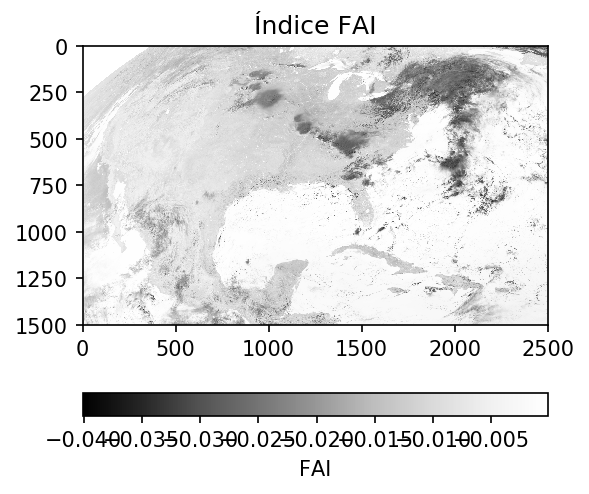

In [17]:
#Graficar el índice FAI
fig = plt.figure(figsize=(4,4),dpi=150)
#im = plt.imshow(Ch2_rad, vmin=0.0, vmax=1.0, cmap='Greys_r')
im = plt.imshow(FAI, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
#cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('FAI')
plt.title('Índice FAI')
plt.show()

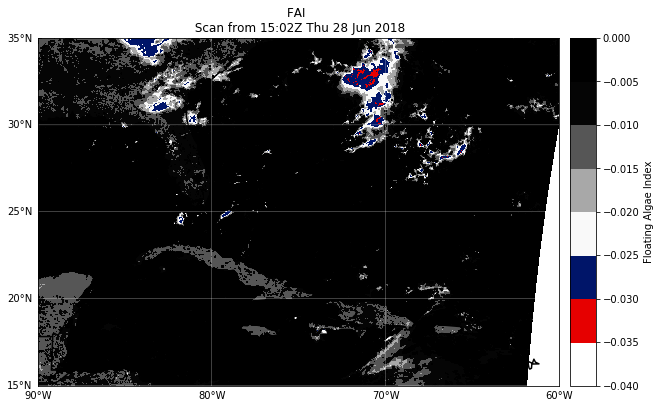

In [23]:
bmap = Basemap(projection='cyl', 
               llcrnrlon=-90, urcrnrlon=-60,
               llcrnrlat=15,   urcrnrlat=35,  resolution='l')

# Plot GOES-16 Channel using 170 and 378 as the temperature thresholds
bmap.contourf(lons,lats,FAI,cmap=cpt_convert)

# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=1.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.5, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.5, color='white', labels=[True, False, False, True])

# Insert the legend
bmap.colorbar(location='right', label='Floating Algae Index')

date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
plt.title("FAI \n Scan from " +date_formatted)

# Show the plot
plt.rcParams['figure.figsize'] = (10,20)
plt.show()

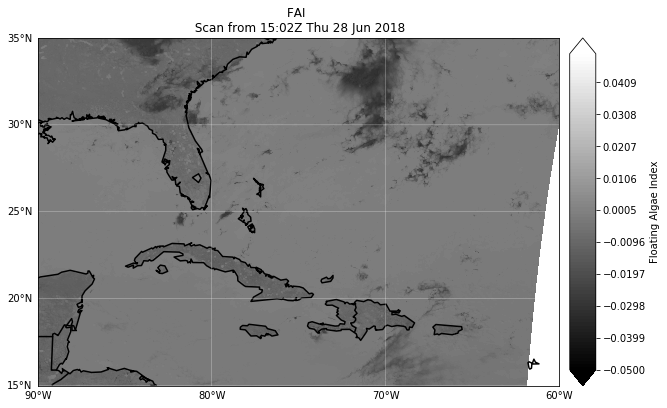

In [22]:
plt.figure(figsize=(10,10))# Create the basemap reference for the Satellite Projection
bmap = Basemap(projection='cyl', 
               llcrnrlon=-90, urcrnrlon=-60,
               llcrnrlat=15,   urcrnrlat=35,  resolution='l')

levels=np.linspace(-0.05, 0.05, 100)
bmap.contourf(lons,lats,FAI, 
              levels=levels, cmap="gist_gray", extend='both')

# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=1.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.5, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.5, color='white', labels=[True, False, False, True])

# Insert the legend
bmap.colorbar(location='right', label='Floating Algae Index')

date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
plt.title("FAI \n Scan from " +date_formatted)

plt.show()

## FAI 2
Ahora, se puede calcular una segunda opción del FAI, utilizando 
el canal 5 ("Snow/Ice)" 1.6 µm), qué aún es parte del SWIR, pero a diferencia que tiene mejor resolución espacial (1km).


#### FAI2 = R(Ch3) – { R(Ch2) + ( R(Ch5) – R(Ch2) ) * (Ch3 – Ch2) / (Ch5 – Ch2)}

Volvemos a importar los datos

In [24]:
## Ch 2
Ch2_nc = Dataset(Ch2_pth)
Ch2_rad = Ch2_nc.variables['Rad'][:]
Ch2_nc.close()
Ch2_nc = None

In [25]:
# Ch 3
Ch3_nc = Dataset(Ch3_pth)
Ch3_rad = Ch3_nc.variables['Rad'][:]
Ch3_nc.close()
Ch3_nc = None

In [38]:
# Ch 5
Ch5_nc = Dataset(Ch5_pth)
Ch5_rad = Ch5_nc.variables['Rad'][:]


In [39]:
## Se extraen los datos de Georeferenciación 
ori_proj = Ch5_nc.variables['goes_imager_projection']
# Satellite height
sat_h = ori_proj.perspective_point_height
# Satellite longitude
sat_lon = ori_proj.longitude_of_projection_origin
# Satellite sweep
sat_sweep = ori_proj.sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = Ch5_nc.variables['x'][:] * sat_h
Y = Ch5_nc.variables['y'][:] * sat_h

p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)


In [40]:
print(sat_lon)
print(sat_h)
np.shape(lats)

-75.0
35786023.0


(3000, 5000)

In [41]:
print(np.min(lats))
print(lats[0,:])

print(np.min(lons))
print(lons[-1,-1])

14.566569931223151
[1.00000000e+30 1.00000000e+30 1.00000000e+30 ... 5.13725632e+01
 5.13735721e+01 5.13745821e+01]
-151.84799952242525
-61.90516023174943


In [42]:
Ch5_nc.close()
Ch5_nc = None

In [30]:
print("Ch2",np.shape(Ch2_rad))
print("Ch3",np.shape(Ch3_rad))
print("Ch5",np.shape(Ch5_rad))

Ch2 (3000, 5000)
Ch3 (3000, 5000)
Ch5 (3000, 5000)


In [29]:
Ch2_rad = rebin(Ch2_rad, [3000, 5000])

In [33]:
#Ch1_ref = reflectance(Ch1_rad, band=1)
Ch2_ref = reflectance(Ch2_rad, band=2)
Ch3_ref = reflectance(Ch3_rad, band=3)
#Ch4_ref = reflectance(Ch4_rad, band=4)
Ch5_ref = reflectance(Ch5_rad, band=5)

Se construye el FAI 2

In [34]:
FAI2 = Ch3_ref - ( Ch2_ref + (Ch5_ref - Ch2_ref) * (Ch3_rad - Ch2_rad)/(Ch5_rad - Ch2_rad))

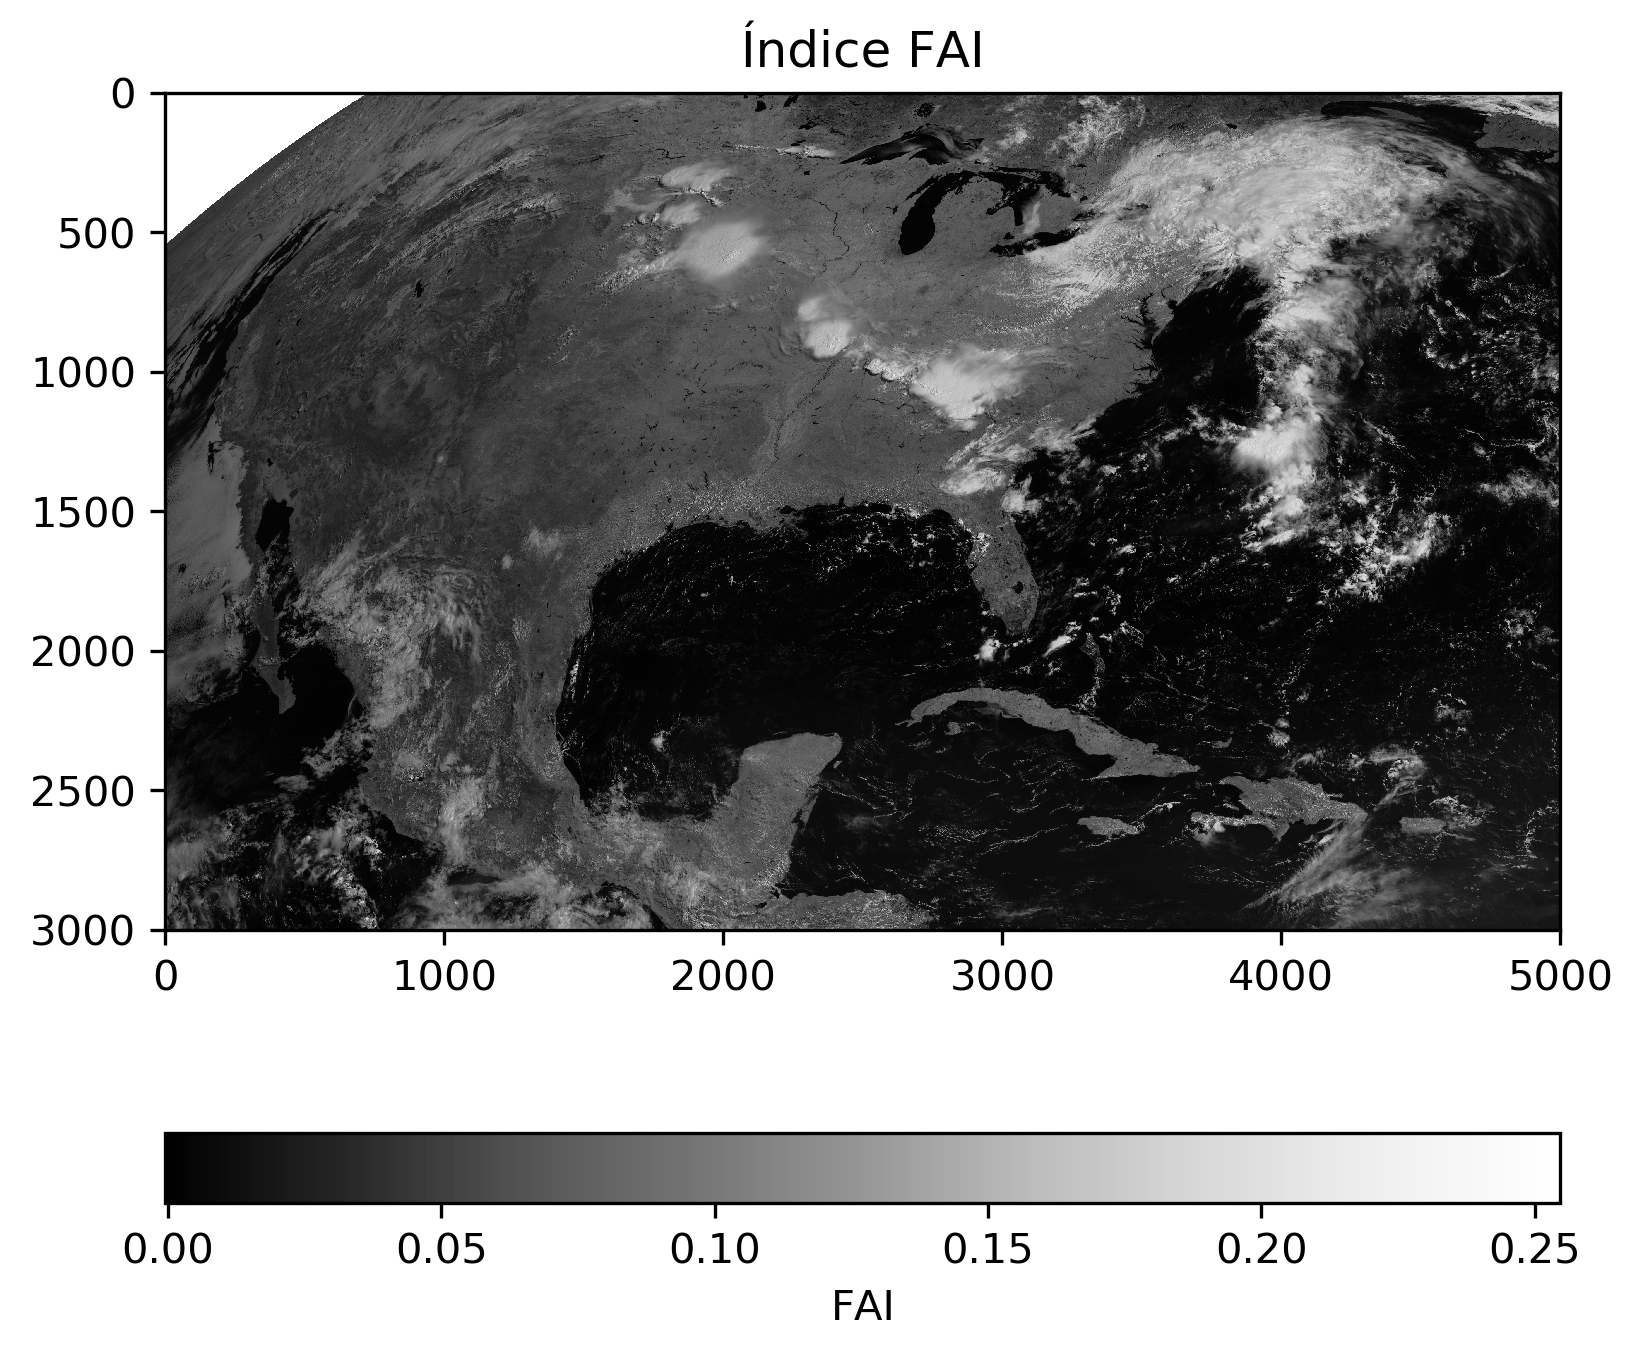

In [35]:
#Graficar el índice FAI
fig = plt.figure(figsize=(6,6),dpi=300)
#im = plt.imshow(Ch2_rad, vmin=0.0, vmax=1.0, cmap='Greys_r')
im = plt.imshow(FAI2, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
#cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('FAI')
plt.title('Índice FAI 2')
plt.show()

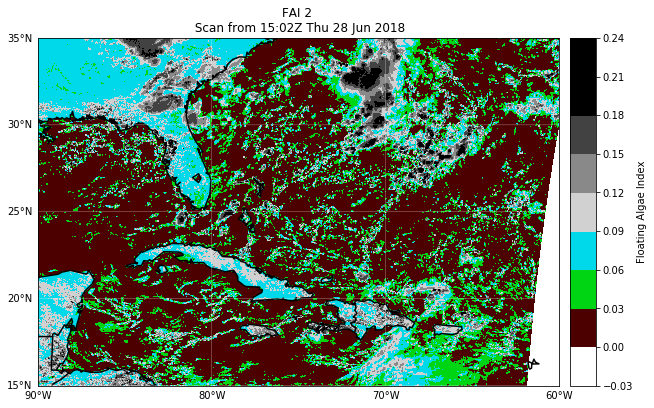

In [45]:
bmap = Basemap(projection='cyl', 
               llcrnrlon=-90, urcrnrlon=-60,
               llcrnrlat=15,   urcrnrlat=35,  resolution='l')

# Plot GOES-16 Channel using 170 and 378 as the temperature thresholds
bmap.contourf(lons,lats,FAI2,cmap=cpt_convert)

# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=1.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.5, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.5, color='white', labels=[True, False, False, True])

# Insert the legend
bmap.colorbar(location='right', label='Floating Algae Index')

date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
plt.title("FAI 2 \n Scan from " +date_formatted)

# Show the plot
plt.rcParams['figure.figsize'] = (10,20)
plt.show()

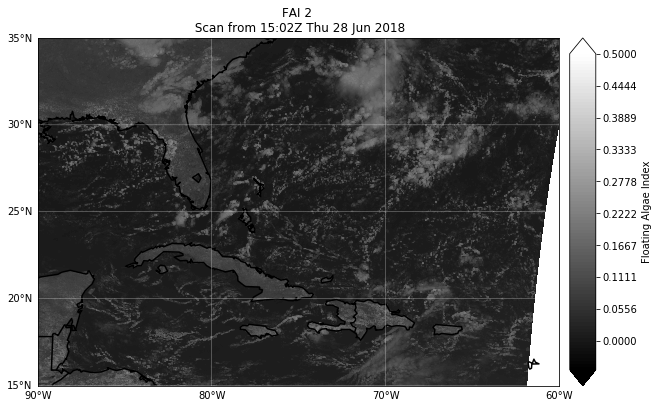

In [47]:
plt.figure(figsize=(10,10))# Create the basemap reference for the Satellite Projection
bmap = Basemap(projection='cyl', 
               llcrnrlon=-90, urcrnrlon=-60,
               llcrnrlat=15,   urcrnrlat=35,  resolution='l')

levels=np.linspace(-0.05, 0.5, 100)
bmap.contourf(lons,lats,FAI2, 
              levels=levels, cmap="gist_gray", extend='both')

# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=1.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.5, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.5, color='white', labels=[True, False, False, True])

# Insert the legend
bmap.colorbar(location='right', label='Floating Algae Index')

date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
plt.title("FAI 2 \n Scan from " +date_formatted)

plt.show()

Existe un índice alternativo (AFAI), que propone los siguientes
canales para la construcción del índice: (λRED = 667 nm, λNIR = 748 nm, λSWIR = 869 nm).
Pero no puede ser calculado para el GOES-R debido
a que no existen suficientes canales cercanos a estas longitudes de onda